## Install Constrastive Dependency

Most of the code was taken from the [contrastive repository](https://github.com/abidlabs/contrastive/tree/master) for reproducibillity goals. For the method, see the author's paper "Exploring Patterns Enriched in a Dataset with Contrastive Principal Component Analysis", *Nature Communications* (2018).

In [ ]:
!git clone https://github.com/abidlabs/contrastive

Cloning into 'contrastive'...
remote: Enumerating objects: 311, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 311 (delta 21), reused 18 (delta 18), pack-reused 282
Receiving objects: 100% (311/311), 30.56 MiB | 25.23 MiB/s, done.
Resolving deltas: 100% (126/126), done.


In [ ]:
pip install contrastive

  Preparing metadata (setup.py) ... done
  Created wheel for contrastive: filename=contrastive-1.2.0-py3-none-any.whl size=6898 sha256=308a9bf9b072cf1c000fb117678a88755b1941e4210f0b6e1b786ed985286e44
  Stored in directory: /root/.cache/pip/wheels/b4/2a/ad/111239c0d6a0b248f0ee4b903b6b44cc9cdfc1cfcff81ebba2
Successfully built contrastive


In [ ]:
from sklearn.decomposition import PCA
from contrastive import CPCA

# **Experiment 1: MNIST Corrupted by Natural Background**

## Load MNIST

In [ ]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline

(train_X, train_y), (test_X, test_y) = mnist.load_data()

target_idx = np.where(train_y<2)[0]
foreground = train_X[target_idx,:][:7038]
target_labels = train_y[target_idx][:7038]

11490434/11490434 [==============================] - 0s 0us/step


In [ ]:
foreground = foreground.reshape((7038,784))
foreground = foreground/255 #Scale images

## PCA on Regular MNIST

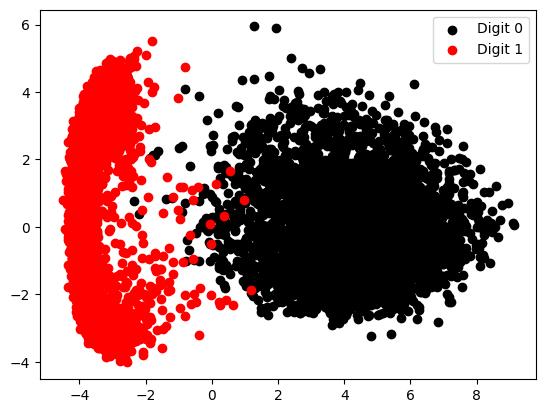

In [ ]:
pca = PCA(n_components=2)
fg = pca.fit_transform(foreground)
colors = ['k','r']

for i, l in enumerate(np.sort(np.unique(target_labels))):
    plt.scatter(fg[np.where(target_labels==l),0],fg[np.where(target_labels==l),1],
                color=colors[i], label='Digit ' +str(l))
plt.legend()

## Load Natural Images from GAN Getting Started Challenge on Kaggle

In [ ]:
import requests as rq

url = 'https://raw.githubusercontent.com/lafirel/COMP551/main/kaggle.json'
response = rq.get(url)

with open('/content/kaggle.json', 'w') as f:
    f.write(response.text)

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle competitions download -c gan-getting-started

 98% 360M/367M [00:04<00:00, 98.9MB/s]
100% 367M/367M [00:05<00:00, 75.9MB/s]


In [ ]:
import zipfile

zip_file_path = '/content/gan-getting-started.zip'
output_folder = '/content/gan-getting-started'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_folder)

## Corrupt MNIST by Superimposing Images

In [ ]:
from PIL import Image
import os

IMAGE_PATH = '/content/gan-getting-started/photo_jpg' #Replace with your own path to downloaded images

natural_images = list() #dictionary of pictures indexed by the pic # and each value is 100x100 image
for filename in os.listdir(IMAGE_PATH):
    if filename.endswith(".jpg"):
        try:
            im = Image.open(os.path.join(IMAGE_PATH,filename))
            im = im.convert("L") #convert to grayscale\
            width, height = im.size
            left = (width - 100) / 2
            top = (height - 100) / 2
            right = (width + 100) / 2
            bottom = (height + 100) / 2
            img_crop = im.crop((left, top, right, bottom)) #resize and crop each picture to be 100px by 100px
            #natural_images.append(np.reshape(img_crop, [10000]))
            img_array = np.array(img_crop)
            natural_images.append(img_array)
        except Exception as e:
            pass #print(e)

natural_images=np.asarray(natural_images,dtype=float)
natural_images = natural_images.reshape((7038, 10000))
natural_images/=255 #rescale to be 0-1
print("Array of grass images:",natural_images.shape)

Array of grass images: (7038, 10000)


## Some Example Images

In [ ]:
np.random.seed(0) # for reproducibility

rand_indices =  np.random.permutation(natural_images.shape[0]) # just shuffles the indices
split = int(len(rand_indices)/2)
target_indices = rand_indices[0:split] # choose the first half of images to be superimposed on target
background_indices = rand_indices[split:] # choose the second half of images to be background dataset

target = np.zeros(foreground.shape)
background = np.zeros(foreground.shape)

for i in range(target.shape[0]):
    idx = np.random.choice(target_indices) # randomly pick a image
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    superimposed_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])
    target[i] = 0.25*(foreground[i]) + superimposed_patch

    idx = np.random.choice(background_indices) # randomly pick a image
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    background_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])
    background[i] = background_patch

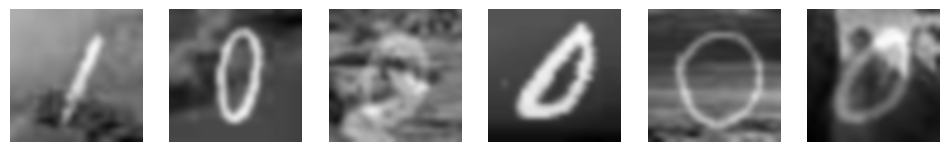

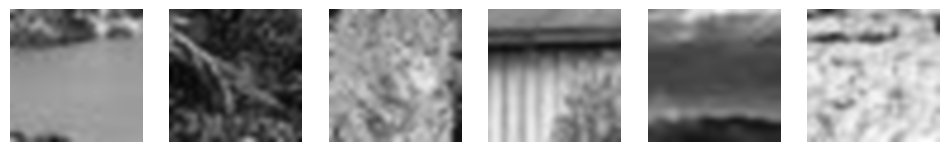

In [ ]:
n_show=6

plt.figure(figsize=[12,12])
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    idx=np.random.randint(1500)
    plt.imshow(np.reshape(target[idx,:],[28,28]), cmap='gray', interpolation="bicubic")
    plt.axis('off')

plt.figure(figsize=[12,12])
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    idx=np.random.randint(1500)
    plt.imshow(np.reshape(background[idx,:],[28,28]),cmap='gray', interpolation="bicubic")
    plt.axis('off')

## PCA on Corrupted MNIST

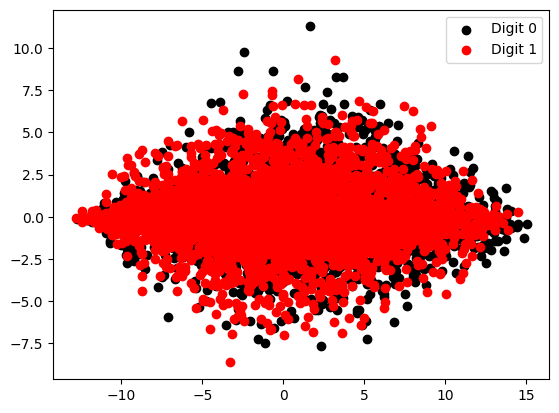

In [ ]:
pca = PCA(n_components=2)
fg = pca.fit_transform(target)

for i, l in enumerate(np.sort(np.unique(target_labels))):
    plt.scatter(fg[np.where(target_labels==l),0],fg[np.where(target_labels==l),1],
                color=colors[i], label='Digit ' +str(l))
plt.legend()

## Perform Contrastive PCA

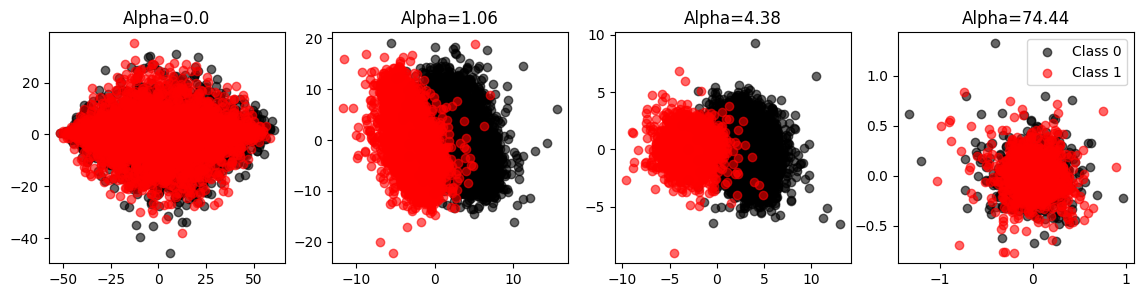

In [ ]:
mdl = CPCA()
projected_data = mdl.fit_transform(target, background, plot=True, active_labels=target_labels)

## Features Captured by PCA vs. cPCA

Text(0.5, 1.0, 'Contributions of Pixels to cPC1')

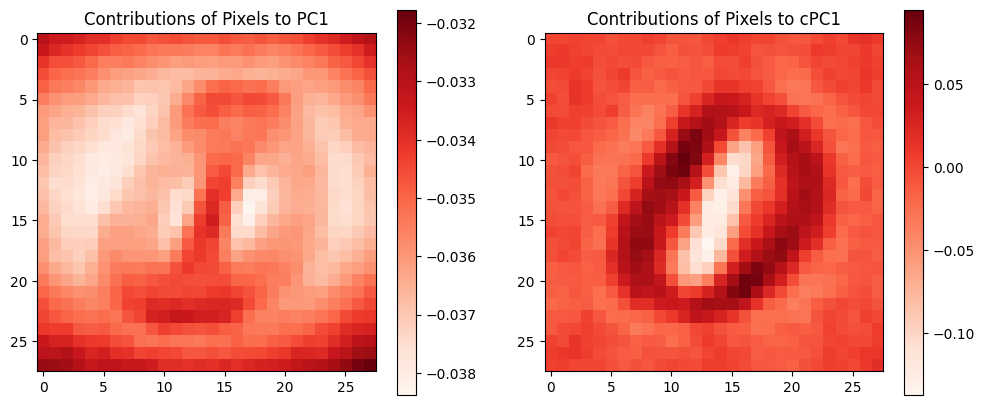

In [ ]:
plt.figure(figsize=[12,5])
w, v = np.linalg.eig(mdl.fg_cov)
idx = np.argmax(w)
plt.subplot(1,2,1)
plt.imshow(v[:,idx].reshape(28,28),cmap='Reds')
plt.colorbar()
plt.title('Contributions of Pixels to PC1')

w, v = np.linalg.eig(mdl.fg_cov - 5.54*mdl.bg_cov) # the value 5.54 is taken from the previous diagram, where alpha=5.54 separates the clusters most clearly
idx = np.argmax(w)
plt.subplot(1,2,2)
plt.imshow(v[:,idx].reshape(28,28),cmap='Reds')
plt.colorbar()
plt.title('Contributions of Pixels to cPC1')

## Denoising with PCA vs. cPCA

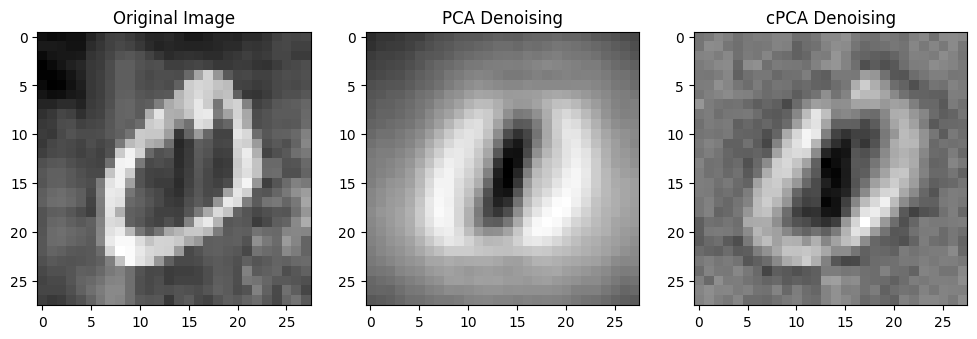

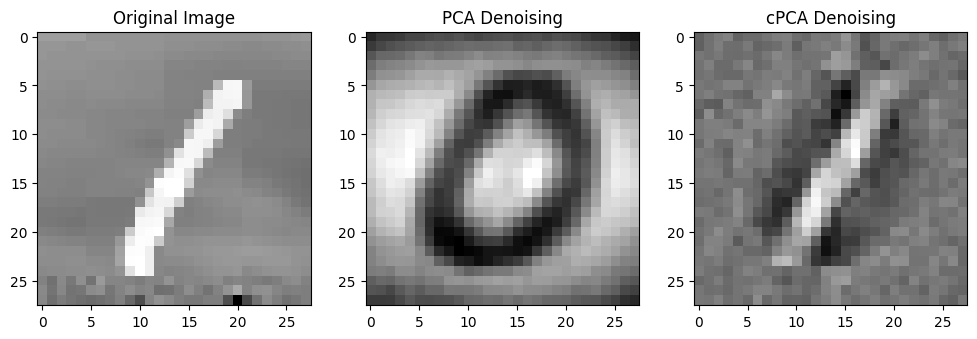

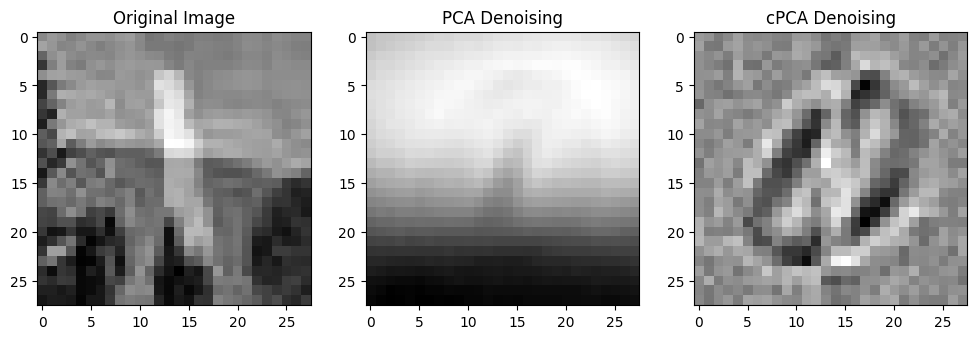

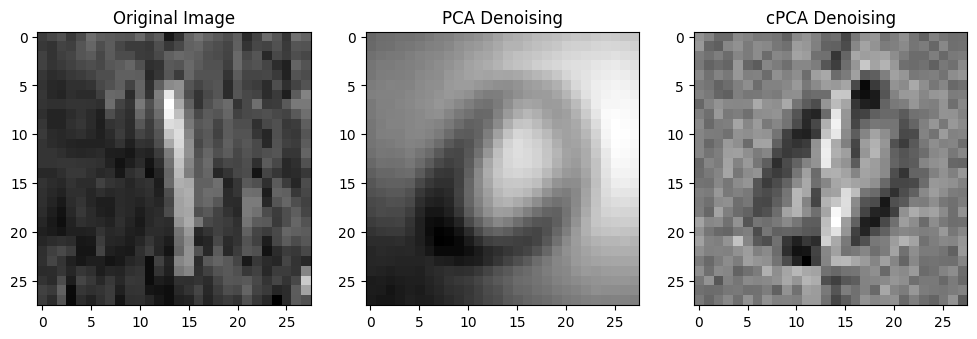

In [ ]:
n_components = 5
for idx in range(4):
    image = target[idx:idx+1]
    plt.figure(figsize=[12,12])
    plt.subplot(1,3,1)
    plt.imshow(image.reshape(28,28),cmap='gray')
    plt.title('Original Image')

    w, v = np.linalg.eig(mdl.fg_cov)
    indices = np.argsort(w)[::-1][:n_components]
    image_ = image.dot(v[:,indices])
    image_ = image_.dot(v[:,indices].T) #keep only the top components of the image
    plt.subplot(1,3,2)
    plt.imshow(image_.reshape(28,28),cmap='gray')
    plt.title('PCA Denoising')

    w, v = np.linalg.eig(mdl.fg_cov - 5.54*mdl.bg_cov) # the value 4.38 is taken from the plot that is two plots previous to this one, where alpha=4.38 separates the clusters most clearly
    indices = np.argsort(w)[::-1][:n_components]
    image_ = image.dot(v[:,indices])
    image_ = image_.dot(v[:,indices].T) #keep only the top components of the image
    plt.subplot(1,3,3)
    plt.imshow(image_.reshape(28,28),cmap='gray')
    plt.title('cPCA Denoising')

#**Experiment 2: Mice Protein Expression**

## Check Files in Local Directory

In [ ]:
import os

print(os.listdir())

['.config', 'contrastive', 'sample_data']


## Load Data

In [ ]:
DATA_CORTEX_NUCLEAR_FILEPATH = "contrastive/experiments/datasets/Data_Cortex_Nuclear.csv"

In [ ]:
import numpy as np
%matplotlib inline

data = np.genfromtxt(DATA_CORTEX_NUCLEAR_FILEPATH, delimiter=',',
                     skip_header=1,usecols=range(1,78),filling_values=0)
classes = np.genfromtxt(DATA_CORTEX_NUCLEAR_FILEPATH, delimiter=',',
                        skip_header=1,usecols=range(78,81),dtype=None)

<ipython-input-7-bbbec62b2beb>:6: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  classes = np.genfromtxt(DATA_CORTEX_NUCLEAR_FILEPATH, delimiter=',',


In [ ]:
classes[:,-3]

array([b'Control', b'Control', b'Control', ..., b'Ts65Dn', b'Ts65Dn',
       b'Ts65Dn'], dtype='|S9')

## Process Data

In [ ]:
target_idx_A = np.where((classes[:,-1]==b'S/C') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Control'))[0]
target_idx_B = np.where((classes[:,-1]==b'S/C') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Ts65Dn'))[0]

labels = len(target_idx_A)*[0] + len(target_idx_B)*[1]
target_idx = np.concatenate((target_idx_A,target_idx_B))

target = data[target_idx]

background_idx = np.where((classes[:,-1]==b'C/S') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Control'))
background = data[background_idx]

## Run Contrastive PCA

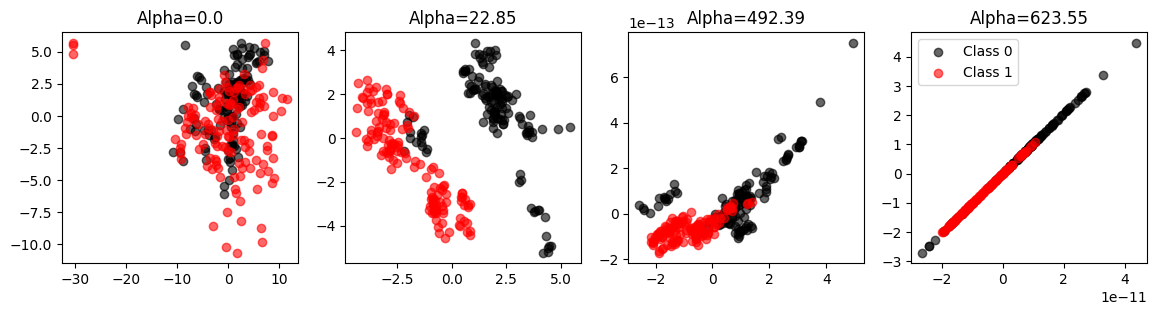

In [ ]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from contrastive import CPCA

mdl = CPCA()
projected_data = mdl.fit_transform(target, background, plot=True, active_labels=labels)

## Run Contrastive for Specific Values of Alpha

Alpha=2

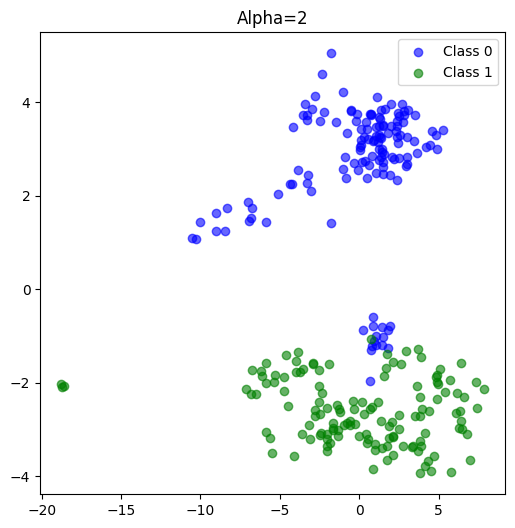

In [ ]:
projected_data = mdl.fit_transform(target, background, plot=True, active_labels=labels, alpha_selection='manual', alpha_value=2, colors=['b', 'g'])


Alpha=7.02

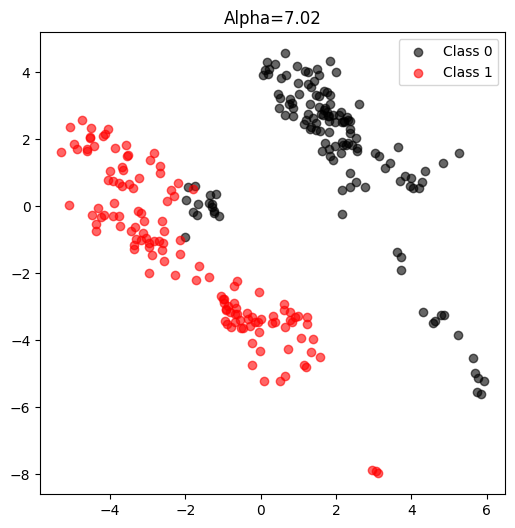

In [ ]:
projected_data = mdl.fit_transform(target, background, plot=True, active_labels=labels, alpha_selection='manual', alpha_value=7.02, colors=['black', 'r'])


Alpha=119.38

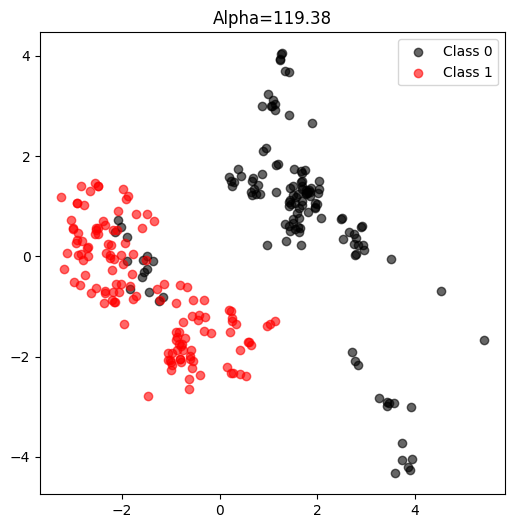

In [ ]:
projected_data = mdl.fit_transform(target, background, plot=True, active_labels=labels, alpha_selection='manual', alpha_value=119.38, colors=['black', 'r'])


Alpha=307.03

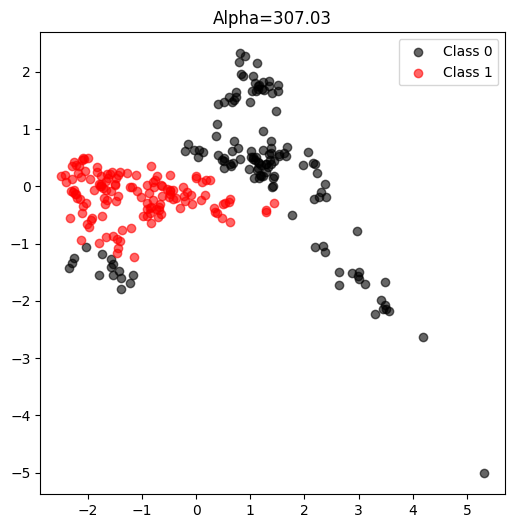

In [ ]:
projected_data = mdl.fit_transform(target, background, plot=True, active_labels=labels, alpha_selection='manual', alpha_value=307.03, colors=['black', 'r'])

## GUI Demo

In [ ]:
projected_data = mdl.fit_transform(target, background, gui=True, active_labels=labels)


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='\\(\\log_{10}{\\alpha} \\)'…

# **Experiment 3**

**Please note**: Experiment 3 code is in the other joined Jupyter Notebook. Please run the other Jupyter Notebook in a separate environment and directory, in order to avoid dependency conflicts.

Running both notebooks separately on Google Colab is recommended.

# **Ablation Experiments**

**Repeating the hand-written digits experiment with a smaller dataset**

In [ ]:
!kaggle datasets download -d timofeymoiseev/grass

grass.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
zip_file_path = '/content/grass.zip'

output_folder = '/content/grass'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the contents of the zip file to the specified directory
    zip_ref.extractall(output_folder)

In [ ]:
IMAGE_PATH = '/content/grass/training/training/image' #Replace with your own path to downloaded images

natural_images = list() #dictionary of pictures indexed by the pic # and each value is 100x100 image
for filename in os.listdir(IMAGE_PATH):
    if filename.endswith(".jpg"):
        try:
            im = Image.open(os.path.join(IMAGE_PATH,filename))
            im = im.convert("L") #convert to grayscale\
            width, height = im.size
            left = (width - 100) / 2
            top = (height - 100) / 2
            right = (width + 100) / 2
            bottom = (height + 100) / 2
            img_crop = im.crop((left, top, right, bottom)) #resize and crop each picture to be 100px by 100px
            #natural_images.append(np.reshape(img_crop, [10000]))
            img_array = np.array(img_crop)
            natural_images.append(img_array)
        except Exception as e:
            pass #print(e)

natural_images=np.asarray(natural_images,dtype=float)
natural_images = natural_images.reshape((1500, 10000))
natural_images/=255 #rescale to be 0-1
print("Array of grass images:",natural_images.shape)

Array of grass images: (1500, 10000)


In [ ]:
np.random.seed(0) # for reproducibility
foreground = foreground[0:1500,:]
target_labels = target_labels[0:1500]

rand_indices =  np.random.permutation(natural_images.shape[0]) # just shuffles the indices
split = int(len(rand_indices)/2)
target_indices = rand_indices[0:split] # choose the first half of images to be superimposed on target
background_indices = rand_indices[split:] # choose the second half of images to be background dataset

target = np.zeros(foreground.shape)
background = np.zeros(foreground.shape)

for i in range(target.shape[0]):
    idx = np.random.choice(target_indices) # randomly pick a image
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    superimposed_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])
    target[i] = 0.25*(foreground[i]) + superimposed_patch

    idx = np.random.choice(background_indices) # randomly pick a image
    loc = np.random.randint(70,size=(2)) # randomly pick a region in the image
    background_patch = np.reshape(np.reshape(natural_images[idx,:],[100,100])[loc[0]:loc[0]+28,:][:,loc[1]:loc[1]+28] ,[1,784])
    background[i] = background_patch

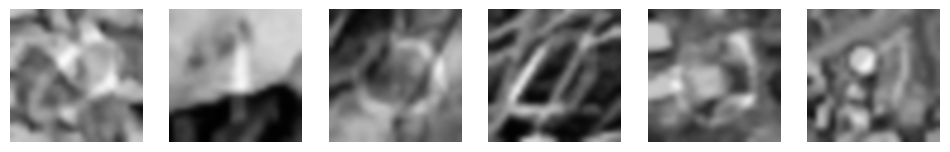

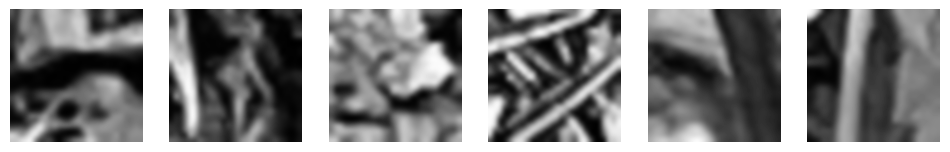

In [ ]:
n_show=6

plt.figure(figsize=[12,12])
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    idx=np.random.randint(1500)
    plt.imshow(np.reshape(target[idx,:],[28,28]), cmap='gray', interpolation="bicubic")
    plt.axis('off')

plt.figure(figsize=[12,12])
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    idx=np.random.randint(1500)
    plt.imshow(np.reshape(background[idx,:],[28,28]),cmap='gray', interpolation="bicubic")
    plt.axis('off')

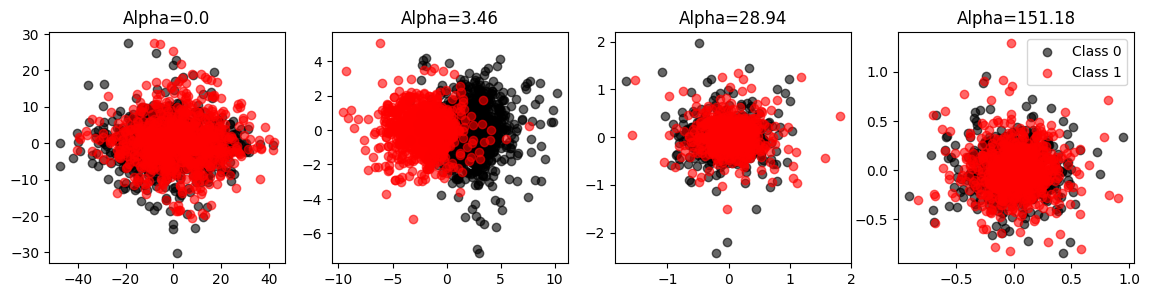

In [ ]:
mdl = CPCA()
projected_data = mdl.fit_transform(target, background, plot=True, active_labels=target_labels)

Text(0.5, 1.0, 'Contributions of Pixels to cPC1')

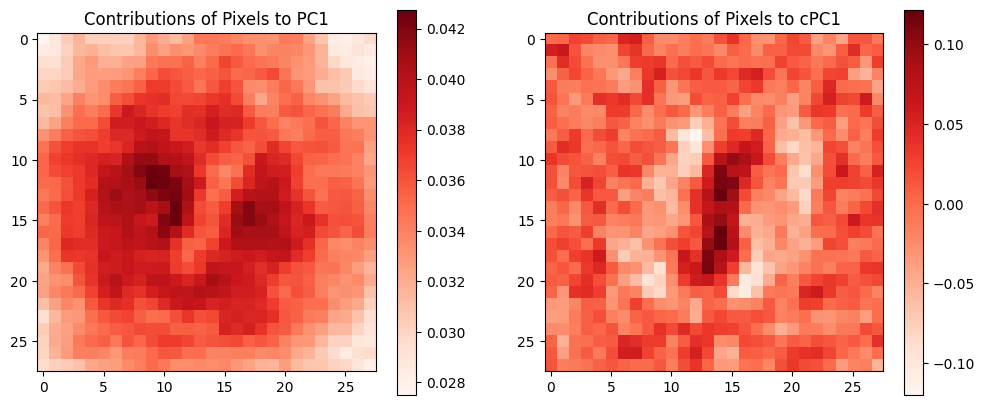

In [ ]:
plt.figure(figsize=[12,5])
w, v = np.linalg.eig(mdl.fg_cov)
idx = np.argmax(w)
plt.subplot(1,2,1)
plt.imshow(v[:,idx].reshape(28,28),cmap='Reds')
plt.colorbar()
plt.title('Contributions of Pixels to PC1')

w, v = np.linalg.eig(mdl.fg_cov - 3.46*mdl.bg_cov) # the value 3.46 is taken from the previous diagram, where alpha=4.38 separates the clusters most clearly
idx = np.argmax(w)
plt.subplot(1,2,2)
plt.imshow(v[:,idx].reshape(28,28),cmap='Reds')
plt.colorbar()
plt.title('Contributions of Pixels to cPC1')

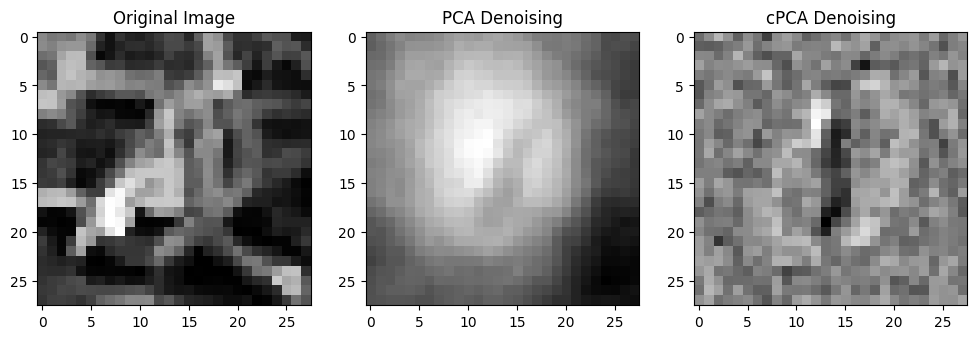

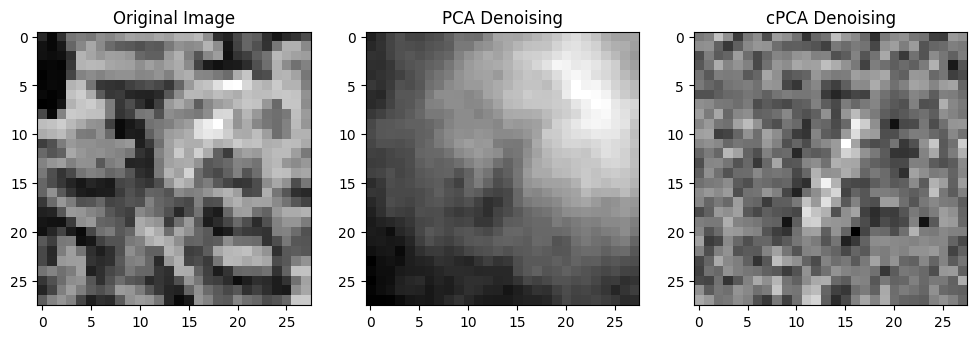

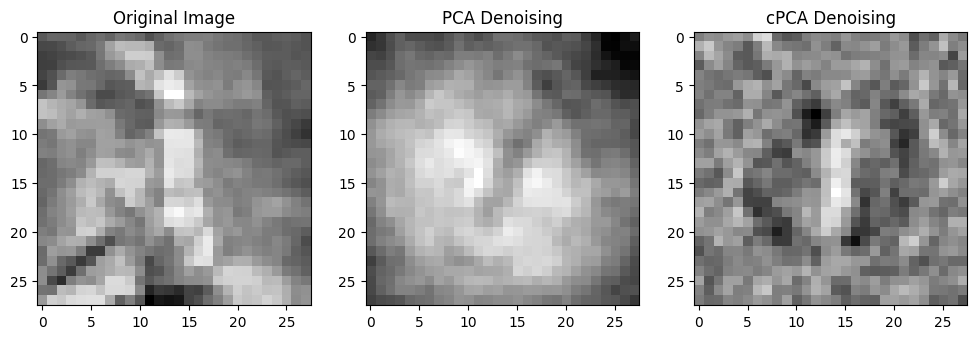

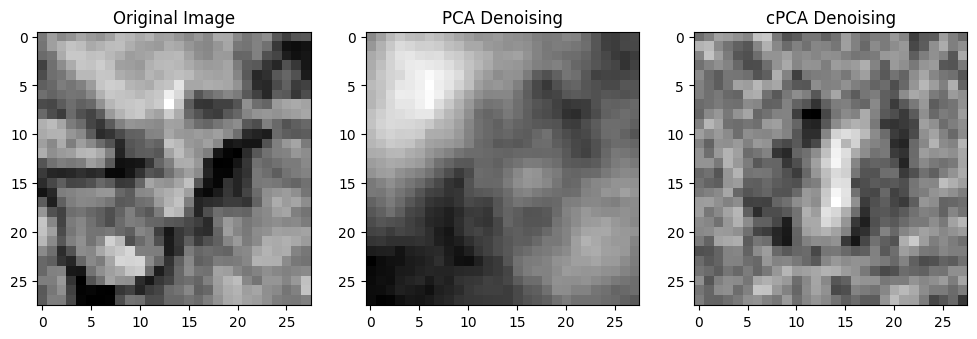

In [ ]:
n_components = 5
for idx in range(4):
    image = target[idx:idx+1]
    plt.figure(figsize=[12,12])
    plt.subplot(1,3,1)
    plt.imshow(image.reshape(28,28),cmap='gray')
    plt.title('Original Image')

    w, v = np.linalg.eig(mdl.fg_cov)
    indices = np.argsort(w)[::-1][:n_components]
    image_ = image.dot(v[:,indices])
    image_ = image_.dot(v[:,indices].T) #keep only the top components of the image
    plt.subplot(1,3,2)
    plt.imshow(image_.reshape(28,28),cmap='gray')
    plt.title('PCA Denoising')

    w, v = np.linalg.eig(mdl.fg_cov - 3.46*mdl.bg_cov)
    indices = np.argsort(w)[::-1][:n_components]
    image_ = image.dot(v[:,indices])
    image_ = image_.dot(v[:,indices].T) #keep only the top components of the image
    plt.subplot(1,3,3)
    plt.imshow(image_.reshape(28,28),cmap='gray')
    plt.title('cPCA Denoising')

/usr/local/lib/python3.10/dist-packages/contrastive/__init__.py:40: RuntimeWarning: invalid value encountered in true_divide
  standardized_array =  (array-np.mean(array,axis=0)) / np.std(array,axis=0)


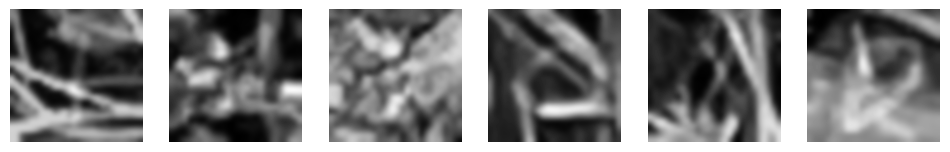

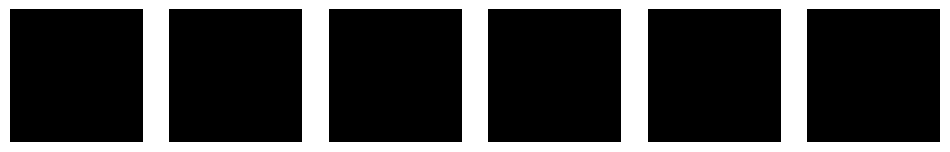

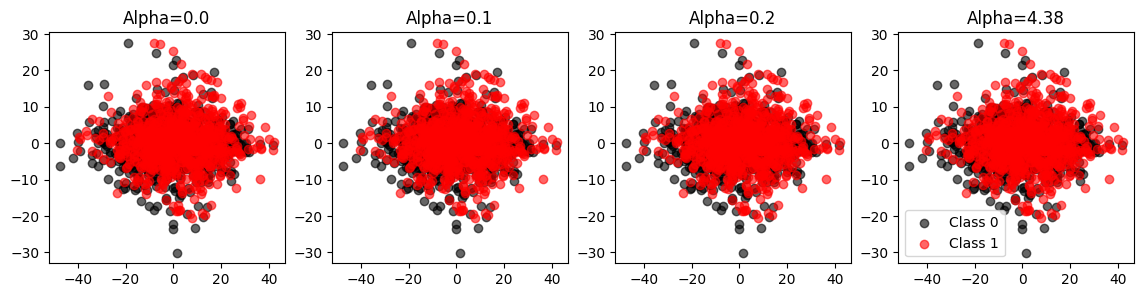

In [ ]:
np.place(background, background != 1, 1)

n_show=6

plt.figure(figsize=[12,12])
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    idx=np.random.randint(1500)
    plt.imshow(np.reshape(target[idx,:],[28,28]), cmap='gray', interpolation="bicubic")
    plt.axis('off')

plt.figure(figsize=[12,12])
for i in range(n_show):
    plt.subplot(1, n_show, i+1)
    idx=np.random.randint(1500)
    plt.imshow(np.reshape(background[idx,:],[28,28]),cmap='gray', interpolation="bicubic")
    plt.axis('off')

mdl = CPCA()
projected_data = mdl.fit_transform(target, background, plot=True, active_labels=target_labels)

# **Additional Experiments**

In [ ]:
import numpy as np
%matplotlib inline

data = np.genfromtxt(DATA_CORTEX_NUCLEAR_FILEPATH,delimiter=',',
                     skip_header=1,usecols=range(1,78),filling_values=0)
classes = np.genfromtxt(DATA_CORTEX_NUCLEAR_FILEPATH,delimiter=',',
                        skip_header=1,usecols=range(78,81),dtype=None)

In [ ]:
print(data.shape)

(1080, 77)


In [ ]:
# set seed for reproducibility
np.random.seed(8)

In [ ]:
target_idx_A = np.where((classes[:,-1]==b'S/C') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Control'))[0]
target_idx_B = np.where((classes[:,-1]==b'S/C') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Ts65Dn'))[0]

labels = len(target_idx_A)*[0] + len(target_idx_B)*[1]
target_idx = np.concatenate((target_idx_A,target_idx_B))

target = data[target_idx]

background_idx = np.where((classes[:,-1]==b'C/S') & (classes[:,-2]==b'Saline') & (classes[:,-3]==b'Control'))
background = data[background_idx]

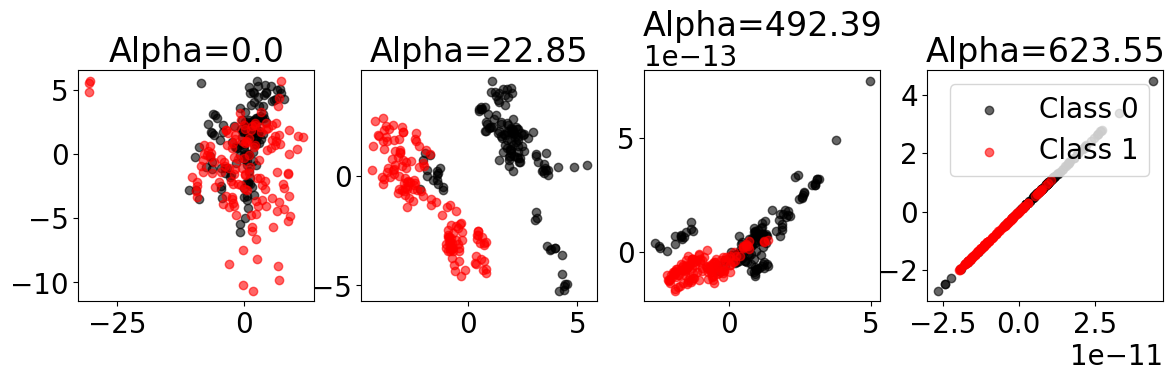

In [ ]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from contrastive import CPCA

mdl = CPCA()
projected_data_for_training = mdl.fit_transform(target, background, plot=True, active_labels=labels)

In [ ]:
projected_data_for_training = mdl.fit_transform(target, background, plot=False, active_labels=labels)
print(len(projected_data_for_training))

4


## **Implement Scikit-Learn PCA**

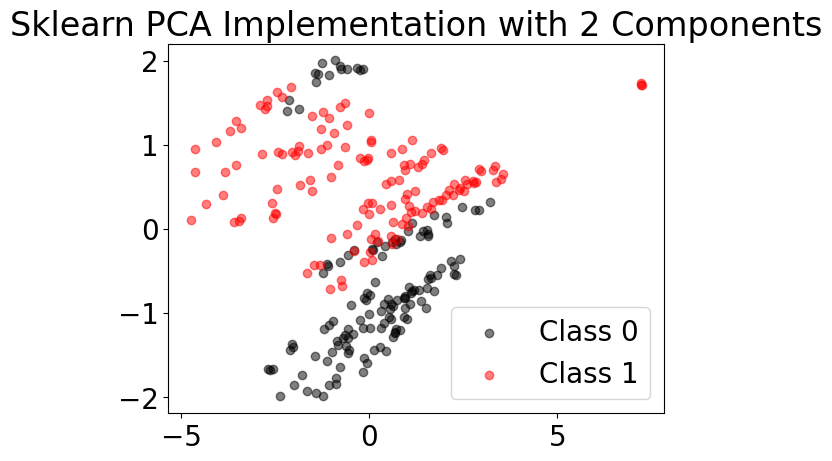

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
sklearn_compressed = pca.fit_transform(target)

LEN_CLASS_0 = len(target_idx_A)

plt.scatter(sklearn_compressed[:LEN_CLASS_0,0], sklearn_compressed[:LEN_CLASS_0,1], label="Class 0", color="black", alpha=0.5)
plt.scatter(sklearn_compressed[LEN_CLASS_0:,0], sklearn_compressed[LEN_CLASS_0:,1], label="Class 1", color="red", alpha=0.5)
plt.title("Sklearn PCA Implementation with 2 Components")
plt.legend()

## **Implement KNN on Sklearn PCA Implementation**

We tried setting the numpy seed to a fixed value earlier in this notebook, but the k-NN algorithm combined with the Scikit-Learn shuffle yields varying test accuracy scores which may differ from the project writeup.*italicized text*


**For PCA:**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(sklearn_compressed, labels)

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
print("Test accuracy:")
print(clf_knn.score(X_test, y_test))

Test accuracy:
0.8529411764705882


**For cPCA, alpha=0:**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(projected_data_for_training[0], labels)

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
print("Test accuracy:")
print(clf_knn.score(X_test, y_test))

Test accuracy:
0.7352941176470589


**For cPCA, alpha=22.8:**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(projected_data_for_training[1], labels)

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
print("Test accuracy:")
print(clf_knn.score(X_test, y_test))

Test accuracy:
0.9558823529411765


**For cPCA, alpha=492.39:**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(projected_data_for_training[2], labels)

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
print("Test accuracy:")
print(clf_knn.score(X_test, y_test))

Test accuracy:
0.7352941176470589


**For cPCA, alpha=623.55:**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(projected_data_for_training[3], labels)

clf_knn = KNeighborsClassifier()
clf_knn.fit(X_train, y_train)
print("Test accuracy:")
print(clf_knn.score(X_test, y_test))

Test accuracy:
0.8088235294117647
